# ECC vs ECP for a noisy circle

In [19]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

### Create pointcloud

In [2]:
def generate_circle(NUMBER_OF_POINTS, seed=42, noise=False):
    point_cloud = []

    rng = np.random.default_rng(seed=seed)
    for a in np.linspace(0, 2 * np.pi, num=NUMBER_OF_POINTS, endpoint=False):
        point = [np.cos(a), np.sin(a)]

        if noise:
            point += rng.normal(scale=noise, size=2)

        point_cloud.append(point)

    point_cloud = np.array(point_cloud)

    return point_cloud


def generate_noisy_points(
    NUMBER_OF_POINTS, xmin=-0.2, xmax=0.2, ymin=-0.2, ymax=0.2, seed=42
):
    point_cloud = []

    rng = np.random.default_rng(seed=seed)

    for i in range(NUMBER_OF_POINTS):
        point_cloud.append([rng.uniform(xmin, xmax), rng.uniform(ymin, ymax)])

    point_cloud = np.array(point_cloud)

    return point_cloud

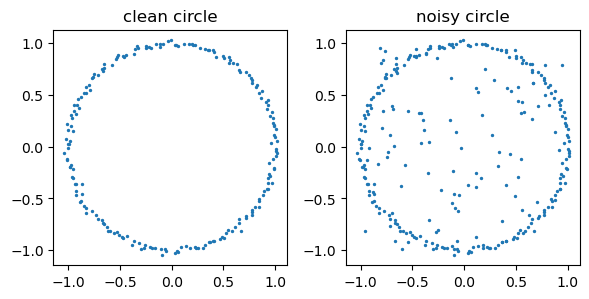

In [3]:
EPSILON = 0.3
DSIGMA = 0.02
NUMBER_OF_POINTS = 200
NUMBER_OF_NOISE = 100

list_of_ECP = []

pointcloud = generate_circle(NUMBER_OF_POINTS, seed=42, noise=DSIGMA)


rng = np.random.default_rng(seed=42)
noisy_pointcloud = np.concatenate(
    (pointcloud, rng.uniform(low=-1, high=1, size=(NUMBER_OF_NOISE, 2)))
)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

axs[0].scatter(pointcloud[:, 0], pointcloud[:, 1], s=2)
axs[0].axis("scaled")
axs[0].set_title("clean circle")

axs[1].scatter(noisy_pointcloud[:, 0], noisy_pointcloud[:, 1], s=2)
axs[1].axis("scaled")
axs[1].set_title("noisy circle")

plt.tight_layout()
plt.show()

## ECC

In [28]:
from pyEulerCurves import ECC_from_pointcloud, plot_euler_curve

In [29]:
trans = ECC_from_pointcloud(
    epsilon=EPSILON, workers=8  # max filtration  # number of CPU cores
)

In [30]:
%%time
ecc = trans.fit_transform(pointcloud)

CPU times: user 36.5 ms, sys: 60 ms, total: 96.5 ms
Wall time: 1.12 s


In [31]:
%%time
noisy_ecc = trans.fit_transform(noisy_pointcloud)

CPU times: user 54.2 ms, sys: 55.8 ms, total: 110 ms
Wall time: 1.08 s


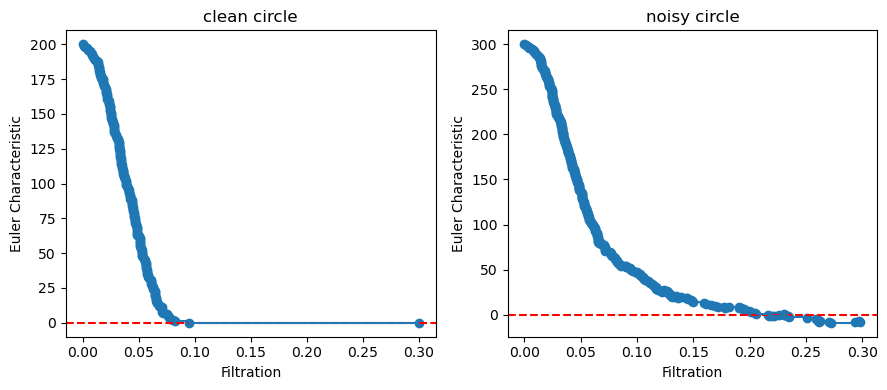

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].axhline(y=0, color="red", linestyle="--")
plot_euler_curve(ecc + [[EPSILON, 0]], with_lines=True, this_ax=axs[0])
axs[0].set_title("clean circle")

axs[1].axhline(y=0, color="red", linestyle="--")
plot_euler_curve(noisy_ecc, with_lines=True, this_ax=axs[1])
axs[1].set_title("noisy circle")

plt.tight_layout()
plt.savefig("noisy_circle_ECC.png", dpi=200)
plt.show()

## ECP with radius and density

In [4]:
import src.purepyECP as pure
from src.bifiltration_utils import EC_at_bifiltration, plot_ECP, difference_ECP

In [5]:
# from scipy.stats import gaussian_kde

# kde = gaussian_kde(pointcloud.T)
# # Estimate the density at every point in the scatter plot
# vertex_filtrations = kde(pointcloud.T) * -1

# kde = gaussian_kde(noisy_pointcloud.T)
# # Estimate the density at every point in the scatter plot
# noisy_vertex_filtrations = kde(noisy_pointcloud.T) * -1

In [6]:
from sklearn.neighbors import NearestNeighbors

NN = 10

neigh = NearestNeighbors(n_neighbors=NN, radius=1)
neigh.fit(pointcloud)
dm, _ = neigh.kneighbors(pointcloud, NN, return_distance=True)
vertex_filtrations = dm[:, NN - 1]


neigh = NearestNeighbors(n_neighbors=NN, radius=1)
neigh.fit(noisy_pointcloud)
dm, _ = neigh.kneighbors(noisy_pointcloud, NN, return_distance=True)
noisy_vertex_filtrations = dm[:, NN - 1]

In [7]:
# vertex_filtrations = pure.gaussian_density(pointcloud, 0.2) * -1
# noisy_vertex_filtrations = pure.gaussian_density(noisy_pointcloud, 0.2) * -1

# print(vertex_filtrations.min(), vertex_filtrations.max())
# print(noisy_vertex_filtrations.min(), noisy_vertex_filtrations.max())

In [8]:
vertex_filtrations[:10]

array([0.14925578, 0.15354682, 0.15471431, 0.14345082, 0.15486509,
       0.14293953, 0.1626674 , 0.15354682, 0.14345082, 0.16928826])

In [9]:
noisy_vertex_filtrations[:10]

array([0.1298635 , 0.14165082, 0.13772077, 0.13452632, 0.1298635 ,
       0.13632293, 0.12704267, 0.13615725, 0.14250594, 0.16895829])

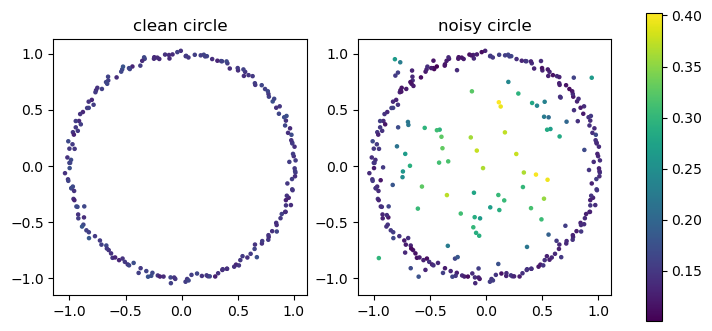

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

vmin = np.min(np.concatenate((vertex_filtrations, noisy_vertex_filtrations)))
vmax = np.max(np.concatenate((vertex_filtrations, noisy_vertex_filtrations)))


pts0 = axs[0].scatter(
    pointcloud[:, 0], pointcloud[:, 1], c=vertex_filtrations, vmin=vmin, vmax=vmax, s=5
)
# fig.colorbar(pts0, ax=axs[0])
axs[0].axis("scaled")
axs[0].set_title("clean circle")

pts1 = axs[1].scatter(
    noisy_pointcloud[:, 0],
    noisy_pointcloud[:, 1],
    c=noisy_vertex_filtrations,
    vmin=vmin,
    vmax=vmax,
    s=5,
)
fig.colorbar(pts1, ax=[axs[0], axs[1]])
axs[1].axis("scaled")
axs[1].set_title("noisy circle")

# fig.suptitle("pointclouds colored by each point density")
# plt.tight_layout()
plt.savefig("noisy_circle_density.pdf")
plt.show()

In [11]:
%%time
clean_contributions, num_simplices = pure.compute_local_contributions(pointcloud, EPSILON, vertex_filtrations)

100%|██████████| 200/200 [00:00<00:00, 444.39it/s]

CPU times: user 415 ms, sys: 72.2 ms, total: 487 ms
Wall time: 470 ms


In [12]:
%%time
noisy_contributions, noisy_num_simplices = pure.compute_local_contributions(noisy_pointcloud, 
                                                                            EPSILON, noisy_vertex_filtrations)

100%|██████████| 300/300 [00:05<00:00, 55.91it/s] 

CPU times: user 5.22 s, sys: 144 ms, total: 5.37 s
Wall time: 5.37 s


In [15]:
len(clean_contributions)

659

In [24]:
clean_contributions[0]

((0, 0.12610937772856617), 1)

In [26]:
pd.DataFrame(
    data=[[row[0][0], row[0][1], row[1]] for row in clean_contributions]
).to_csv("clean_circle.csv", index=False, header=False)

In [27]:
pd.DataFrame(
    data=[[row[0][0], row[0][1], row[1]] for row in noisy_contributions]
).to_csv("noisy_circle.csv", index=False, header=False)

0 0.2996943694817979 0.10078536533788429 0.4024226634116707


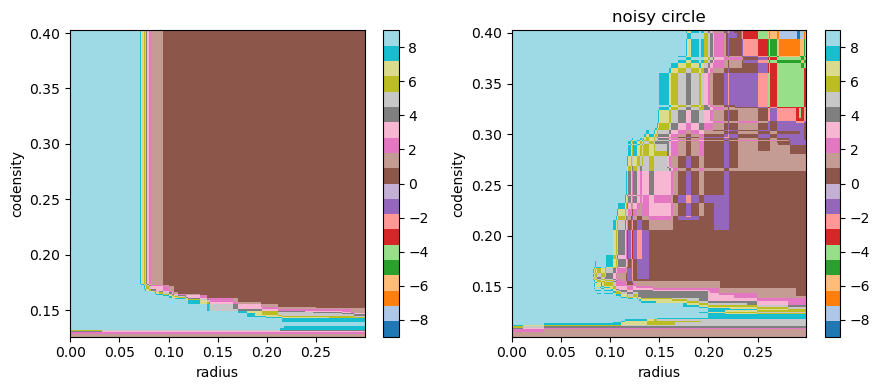

In [13]:
import matplotlib as mpl

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

f1max = max(
    max([c[0][0] for c in clean_contributions]),
    max([c[0][0] for c in noisy_contributions]),
)
f2max = max(
    max([c[0][1] for c in clean_contributions]),
    max([c[0][1] for c in noisy_contributions]),
)
f2min = min(
    min([c[0][1] for c in clean_contributions]),
    min([c[0][1] for c in noisy_contributions]),
)

f2max = max(
    max([c[0][1] for c in clean_contributions]),
    max([c[0][1] for c in noisy_contributions]),
)

print(0, f1max, f2min, f2max)

plot_ECP(
    clean_contributions,
    (0, f1max, 0.1325, f2max),
    axs[0],
    norm=mpl.colors.Normalize(vmin=-9, vmax=9),
    cmap="tab20",
    colorbar=True,
)
axs[0].set_xlabel("radius")
axs[0].set_ylabel("codensity")
axs[1].set_title("clean circle")

plot_ECP(
    noisy_contributions,
    (0, f1max, 0.1325, f2max),
    axs[1],
    norm=mpl.colors.Normalize(vmin=-9, vmax=9),
    cmap="tab20",
    colorbar=True,
)
axs[1].set_xlabel("radius")
axs[1].set_ylabel("codensity")
axs[1].set_title("noisy circle")

# fig.suptitle("Euler Characteristic Profiles")
plt.tight_layout()
plt.savefig("noisy_circle_ECP.png", dpi=200)
plt.show()

In [19]:
def get_mesh(contributions, dims):

    f1min, f1max, f2min, f2max = dims

    f1_list = [f1min] + sorted(set([c[0][0] for c in contributions])) + [f1max]
    f2_list = (
        [f2min]
        + sorted(set([c[0][1] for c in contributions if c[0][1] > f2min]))
        + [f2max]
    )

    Z = np.zeros((len(f2_list) - 1, len(f1_list) - 1))

    for i, f1 in enumerate(f1_list[:-1]):
        for j, f2 in enumerate(f2_list[:-1]):
            Z[j, i] = EC_at_bifiltration(contributions, f1, f2)

    return Z, f1_list, f2_list

0 0.2996943694817979 0.10078536533788428 0.4024226634116707


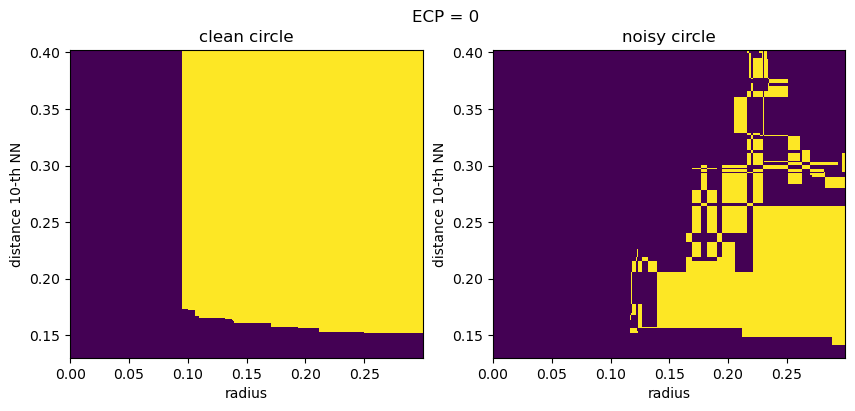

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

f1max = max(
    max([c[0][0] for c in clean_contributions]),
    max([c[0][0] for c in noisy_contributions]),
)
f2max = max(
    max([c[0][1] for c in clean_contributions]),
    max([c[0][1] for c in noisy_contributions]),
)
f2min = min(
    min([c[0][1] for c in clean_contributions]),
    min([c[0][1] for c in noisy_contributions]),
)

f2max = max(
    max([c[0][1] for c in clean_contributions]),
    max([c[0][1] for c in noisy_contributions]),
)

print(0, f1max, f2min, f2max)

Z, f1, f2 = get_mesh(clean_contributions, (0, f1max, 0.13, f2max))
is_zero = (Z == 0).astype(int)
axs[0].pcolormesh(f1, f2, is_zero)

axs[0].set_xlabel("radius")
axs[0].set_ylabel("distance {}-th NN".format(NN))
axs[0].set_title("clean circle")

Z_noise, f1, f2 = get_mesh(noisy_contributions, (0, f1max, 0.13, f2max))
is_zero_noise = (Z_noise == 0).astype(int)
axs[1].pcolormesh(f1, f2, is_zero_noise)


axs[1].set_xlabel("radius")
axs[1].set_ylabel("distance {}-th NN".format(NN))
axs[1].set_title("noisy circle")

fig.suptitle("ECP = 0")
plt.show()